Uploading the dataset that was previously cleaned in Dataiku.

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [2]:
training = pd.read_csv("training.csv", delimiter=",", decimal=".")
test = pd.read_csv("test.csv", delimiter=",", decimal=".")
status_group = pd.read_csv("0bf8bc6e-30d0-4c50-956a-603fc693d966.csv", delimiter=",", decimal=".")
training = pd.merge(training, status_group, left_on='id', right_on='id', how='left')

In [3]:
#Joining both data sets 
test['status_group'] = 0
dataset = training.append(test)

# Feature Engineering

## Deleting features

Even though we will use actual feature selection techniques in the modelling part, here we delete features that we know are irrelevant or redundant.

In [4]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 41 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                74250 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
num_private              74250 non-null int64
basin                    74250 non-null object
subvillage               73780 non-null object
region                   74250 non-null object
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null float64
public_meeting           74250 non-null bool
r

Given the high correlation between some variables, -even in some cases we had identical columns-, we deleted about 9 features to simplify the model. We kept the ones which we condider were more informative and/or diverse vs the target variable.  
Additionally, we will not use *ID*, *date_recorded,* *num_private* nor *recorded_by* features since they aren´t adding any value.

In [5]:
dataset = dataset.drop(['district_code','id','date_recorded', 'longitude', 'latitude', 'wpt_name', 'num_private', 'subvillage', 'region_code', 'ward', 'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_class', 'management_group', 'payment', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group'], axis = 1) 

In [6]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 21 columns):
amount_tsh               74250 non-null float64
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                74250 non-null object
basin                    74250 non-null object
region                   74250 non-null object
lga                      74250 non-null object
population               74250 non-null float64
public_meeting           74250 non-null bool
scheme_management        74250 non-null object
permit                   74250 non-null bool
construction_year        74250 non-null int64
extraction_type_group    74250 non-null object
management               74250 non-null object
payment_type             74250 non-null object
water_quality            74250 non-null object
quality_group            74250 non-null object
quantity_group           74250 non-null object
source                   74250 non-null object
wa

## Transforming features

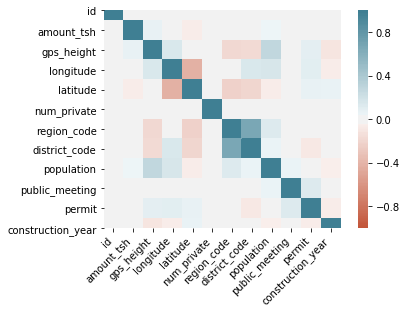

In [7]:
import seaborn as sns

numerical_cols = training.columns[training.dtypes!='category'].tolist()
numVariablesDF = training[numerical_cols]


corr = numVariablesDF.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

 
**Funder and Installer: Feature simplification and reduction**  
Looking at these two variables they wouldn´t support an optimal use of any algorithm since they have around 2k distinct values plus they are categorical features.  
We consider its relevant to know who install the pump, since this are the foundation and initial step to understand who has good quality, material and processes leading to a more lasting functioning pump. Having this variable will also help the minister in the future to decide who can help in the installation stage.  
So in order to help interpretability and keep the variables, we selected the top 20 installers and funders with more experience and remain with those categories which represents about 70% of the dataset. The remaining will be categorized as *OTHERS* since there are a lot which have only installed 1 pump, if we keep them the algorithm will learn too much from singularity cases in the training set. 

In [8]:
#Defining function that keeps top N values of a categorical feature and sets the rest as others. 

def get_n(x,n):
    list_a = set(x.value_counts().index[:n].values) #Gets the top 20 values from the series
    x[~x.isin(list_a)] = 'Other' #vectorisation - boolean mask; tilda - inverting the boolean mask
    return x

In [9]:
#Applying the function to funder and installer features
dataset.funder = get_n(dataset.funder,20)
dataset.installer = get_n(dataset.installer,20)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**pump_age: Feature creation**  
We have pumps constructed from 1960 up to 2013, this is a very large range where technologies and processes have had a significant changed, reason why it’s important to understand how old the pump is. We have created a new feature which will be much more interpretable and have a hierarchical order telling how many years have passed since the pump was constructed instead of the year it was build. 

In [10]:
dataset["pump_age"] = dataset["construction_year"].apply(lambda x: 2020 - x)

**Binning Construction Year: Feature transformation**  
Having a pump constructed in 1960 or 1962 doesn´t really makes a difference, what we want to capture in this feature is homogeneous characteristics in the decade which can show if any period made higher quality pumps or tend fail more. Based on the above we have bin the construction year per decade, ending up with 7 different categories instead of 55. 

In [11]:
#Creating bins for construction_year
bins = [1955, 1970, 1980, 1990, 2000, 2010, 2020]
labels = ["build_1960s", "built_1970s", "built_1980s", "built_1990s", "built_2000s", "built_2010s"]
dataset['construction_year'] = pd.cut(dataset['construction_year'], bins=bins, labels=labels)

#make age column categorical type for algorithm efficiency purposes
dataset['construction_year'] = dataset['construction_year'].astype('category')

**Binning GPS Height: Feature transformation**  
For this variable we have a range of -100 up to 3000 which is a very large range, and again, every small difference is not what we want to capture, we need to make it simpler just to capture a large altitud, medium or low altitud, using as middle point zero where we have app 30% of our information.


In [12]:
#Creating bins for construction_year
bins = [-10000000, 0, 1000, 10000000]
labels = ["Low Altitud", "Medium Altitud", "Large Altitud"]
dataset['gps_height_binned'] = pd.cut(dataset['gps_height'], bins=bins, labels=labels)

#make age column categorical type for algorithm efficiency purposes
dataset['gps_height_binned'] = dataset['gps_height_binned'].astype('category')

In [13]:
dataset[['gps_height_binned', "gps_height"]].head()

,gps_height_binned,gps_height
0,Low Altitud,0
1,Large Altitud,1978
2,Low Altitud,0
3,Large Altitud,1639
4,Low Altitud,0


**LGA: Feature simplification and reduction**  
For this feature we have 125 distinct values, we had identified a common label in the naming contains urban or rural, which will provide information of the surrundings of where the pump is. In case it doesn´t have this label it will remain as others.

In [14]:
#Creating a formula to diferenciate between rural, urban and other
def substring_finder(row_value):
    list_row = row_value.split()
    if "Rural" in list_row:
        return "rural"
    elif "Urban" in list_row:
        return "urban"
    else:
        return "other"

dataset['lga'] = dataset["lga"].apply(substring_finder)

In [15]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 23 columns):
amount_tsh               74250 non-null float64
funder                   74250 non-null object
gps_height               74250 non-null int64
installer                74250 non-null object
basin                    74250 non-null object
region                   74250 non-null object
lga                      74250 non-null object
population               74250 non-null float64
public_meeting           74250 non-null bool
scheme_management        74250 non-null object
permit                   74250 non-null bool
construction_year        74250 non-null category
extraction_type_group    74250 non-null object
management               74250 non-null object
payment_type             74250 non-null object
water_quality            74250 non-null object
quality_group            74250 non-null object
quantity_group           74250 non-null object
source                   74250 non-null object

**Setting the right data types on columns**

In [16]:
bool_cols = ["public_meeting", "permit"]
num_cols = ["amount_tsh", "gps_height","population", "pump_age"]
cat_cols = ["funder", "installer", "basin", "region", "lga", "scheme_management", "construction_year", "extraction_type_group", "management", "payment_type", "water_quality", "quality_group", "quantity_group", "source", "waterpoint_type", "gps_height_binned"]

In [17]:
for column in bool_cols:
    dataset[column] = dataset[column].astype('bool')

for column in num_cols:
    dataset[column] = dataset[column].astype('float64')
    
for column in cat_cols:
    dataset[column] = dataset[column].astype('category')

In [18]:
dataset.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
basin                    0
region                   0
lga                      0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment_type             0
water_quality            0
quality_group            0
quantity_group           0
source                   0
waterpoint_type          0
status_group             0
pump_age                 0
gps_height_binned        0
dtype: int64

**One Hot Encoding**  
We now create the dummified_dataset, which contains normalized values for numerical features, dummied categories for categorical features, and the boolean features as such.

In [19]:
#create dummified dataframe with also transformed numerical values
ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns
dummified_dataset = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset[num_cols])), columns=num_cols).reset_index(drop=True),
                               pd.DataFrame(ohe.fit_transform(dataset[cat_cols]).toarray(), columns=ohe.get_feature_names(cat_cols)).reset_index(drop=True),
                               pd.DataFrame(dataset['status_group']).reset_index(drop=True)],axis=1)


# Modelling

We first start by creating the useful functions needed to model and find insights

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()
    
def get_feature_importance1(clf):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)

def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

We attribute our datframes to variables which will make it easier for the modelling

In [22]:
from sklearn.model_selection import train_test_split

# left is the target variable
X = dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1)
y = dummified_dataset.iloc[0:59400]['status_group']
test_t = dummified_dataset.iloc[59400:].drop(['status_group'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

We then create our baseling model that will serve as a comparison for the the other models.
To do so, we create a logistic regression model, as it is a simple one to put in place and understand, it clearly helps as a comparator for the others.
It gives us an accuracry of 0.744, let's try to improve it.

Accuracy = 0.7440


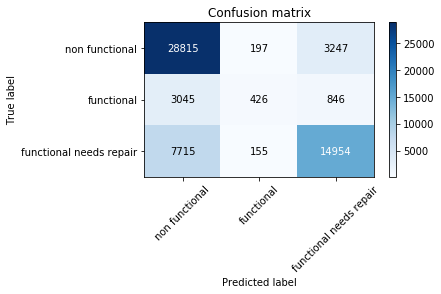

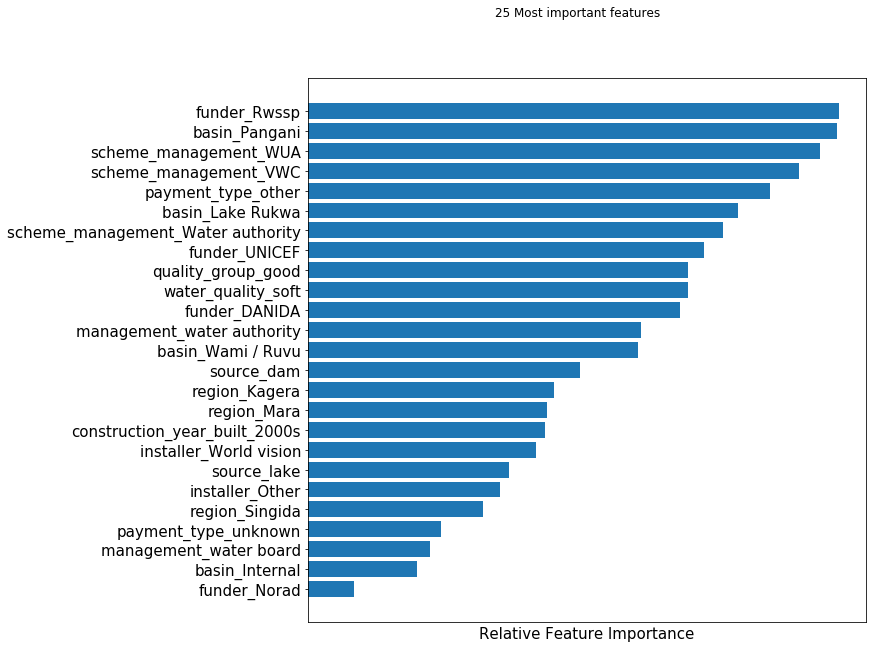

In [23]:
baseline_model, score = train_model(dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1), dummified_dataset.iloc[0:59400]['status_group'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))

## Chi-squared

We use the chi squarred to better understand the relationships between variables and the relative importance of them top try to create a better model.

We were able to get a 0.73 accuracy (lower than our baseline) at first, then lokking at a stepwise methode on chi square we amanged to pinpoint the highest accuracy using a certain amount of variables at 131-133 variables which we select to train another model that gives us a 0.745 accuracy thus a little bit higher than our baseline.

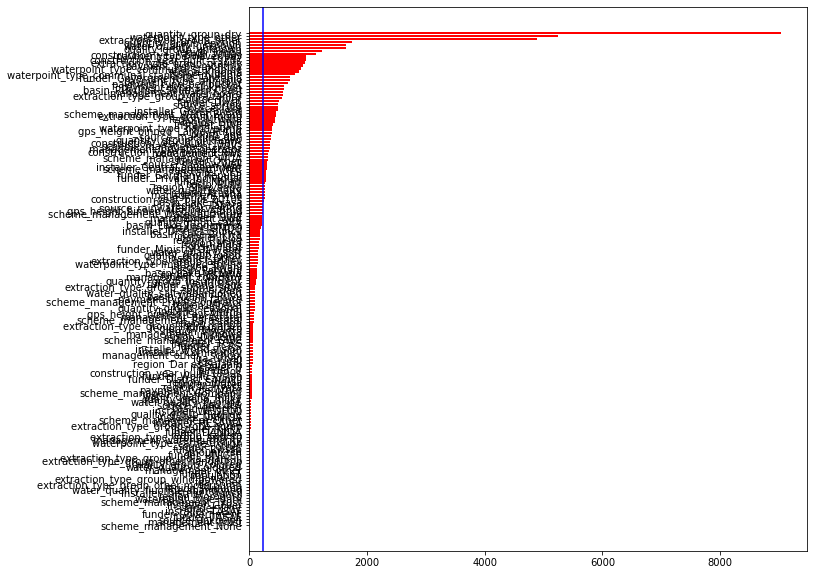

ChiSquared Threshold 228.15445796949405


In [29]:
from sklearn.feature_selection import SelectKBest, chi2
from operator import itemgetter

chi2_selector = SelectKBest(score_func=chi2).fit(dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1), dummified_dataset.iloc[0:59400]['status_group'])

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = defaultdict(float)
for i in range(len(dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1).columns)):
    chi2_features[dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1).columns[indices[i]]] += chi2_selector.scores_[indices[i]]
    
items = sorted(chi2_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(10,10))
plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
plt.barh(list(range(len(keys))), values, color='r', align='center')
chi2_th = pd.Series(list(chi2_features.values())).quantile(0.25)*6
plt.axvline(chi2_th, color='blue')
plt.gca().invert_yaxis()

plt.show()

print("ChiSquared Threshold", chi2_th)

Features to remove = dict_keys(['scheme_management_Water authority', 'installer_DWE', 'management_wug', 'quality_group_salty', 'basin_Lake Tanganyika', 'installer_DMDD', 'installer_District council', 'basin_Lake Rukwa', 'installer_LGA', 'region_Rukwa', 'region_Mara', 'gps_height', 'funder_Ministry Of Water', 'water_quality_soft', 'quality_group_good', 'installer_Other', 'extraction_type_group_afridev', 'waterpoint_type_improved spring', 'region_Pwani', 'basin_Pangani', 'basin_Lake Victoria', 'funder_HESAWA', 'management_company', 'quantity_group_insufficient', 'funder_World Bank', 'extraction_type_group_submersible', 'source_dam', 'water_quality_salty abandoned', 'basin_Wami / Ruvu', 'payment_type_on failure', 'scheme_management_Private operator', 'region_Mbeya', 'quantity_group_seasonal', 'installer_Commu', 'gps_height_binned_Low Altitud', 'management_parastatal', 'scheme_management_Parastatal', 'region_Tanga', 'extraction_type_group_india mark ii', 'region_Kilimanjaro', 'region_Mwanz

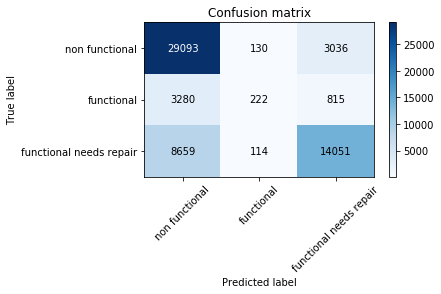

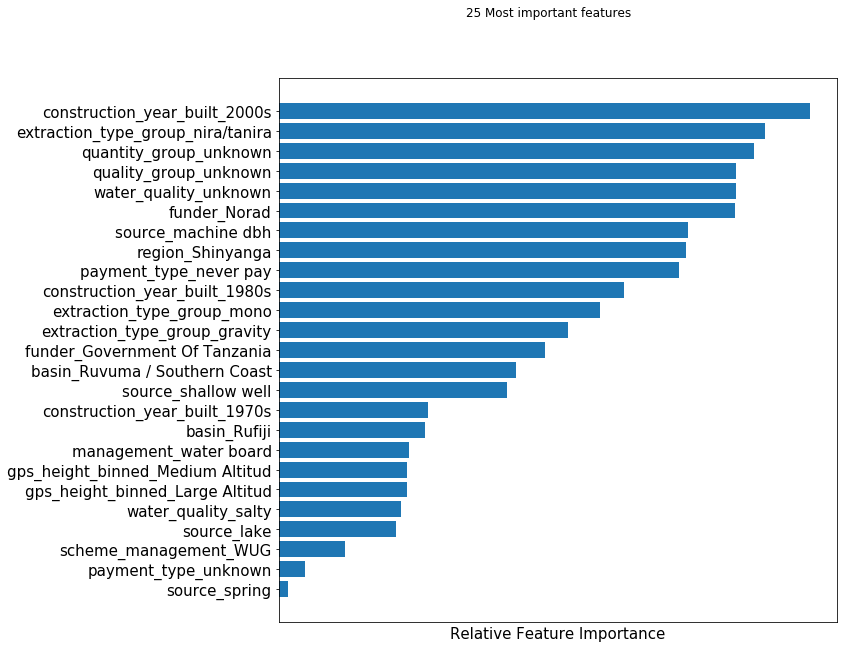

In [30]:
chi2_features_to_remove = dict(filter(lambda x: x[1] <= chi2_th, chi2_features.items())).keys()
print("Features to remove = {}".format(chi2_features_to_remove))
chi2_model, score = train_model(dummified_dataset.iloc[0:59400].drop(list(chi2_features_to_remove)+['status_group'], axis=1), dummified_dataset.iloc[0:59400]['status_group'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))

In [33]:
chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices[i]])

for i in range(1,len(chi2_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[chi2_features[:i]], y_train).predict(X_test[chi2_features[:i]]))))
    print()

Features used to train the model = 1
Accuracy = 0.6455

Features used to train the model = 2
Accuracy = 0.6944

Features used to train the model = 3
Accuracy = 0.6981

Features used to train the model = 4
Accuracy = 0.6960

Features used to train the model = 5
Accuracy = 0.6978

Features used to train the model = 6
Accuracy = 0.6978

Features used to train the model = 7
Accuracy = 0.6997

Features used to train the model = 8
Accuracy = 0.7005

Features used to train the model = 9
Accuracy = 0.7006

Features used to train the model = 10
Accuracy = 0.7065

Features used to train the model = 11
Accuracy = 0.7070

Features used to train the model = 12
Accuracy = 0.7066

Features used to train the model = 13
Accuracy = 0.7078

Features used to train the model = 14
Accuracy = 0.7077

Features used to train the model = 15
Accuracy = 0.7118

Features used to train the model = 16
Accuracy = 0.7139

Features used to train the model = 17
Accuracy = 0.7170

Features used to train the model = 18
Ac

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy = 0.7445

Features used to train the model = 135


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy = 0.7434

Features used to train the model = 136


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy = 0.7442

Features used to train the model = 137


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy = 0.7440

Features used to train the model = 138
Accuracy = 0.7448

Features used to train the model = 139
Accuracy = 0.7440

Features used to train the model = 140
Accuracy = 0.7440

Features used to train the model = 141


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy = 0.7441

Features used to train the model = 142


KeyboardInterrupt: 

In [ ]:
print(chi2_features[:133])

chi2_initial_lm_mod_wrap = linear_model.LogisticRegression(max_iter=10000, penalty='none')
chi2_initial_lm_mod_wrap.fit(X_train[chi2_features[:133]], y_train)

get_feature_importance1(chi2_initial_lm_mod_wrap)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,chi2_initial_lm_mod_wrap.predict(X_test[chi2_features[:133]]))))

## Information gain

Implementing the Information Gain we can measure how predictable each attribute is in compared to the absence feature.

We use it because it is important to know the inclusion or exclusion of a particular feature is in predicting the correct class.

We were able to get a 0.738 accuracy (lower than our baseline) at first, then using a stepwise methode on information gain we managed to pinpoint the highest accuracy using a certain amount of variables at 154 variables which we select to train another model that gives us a 0.7461 accuracy, thus a little higher than our baseline.

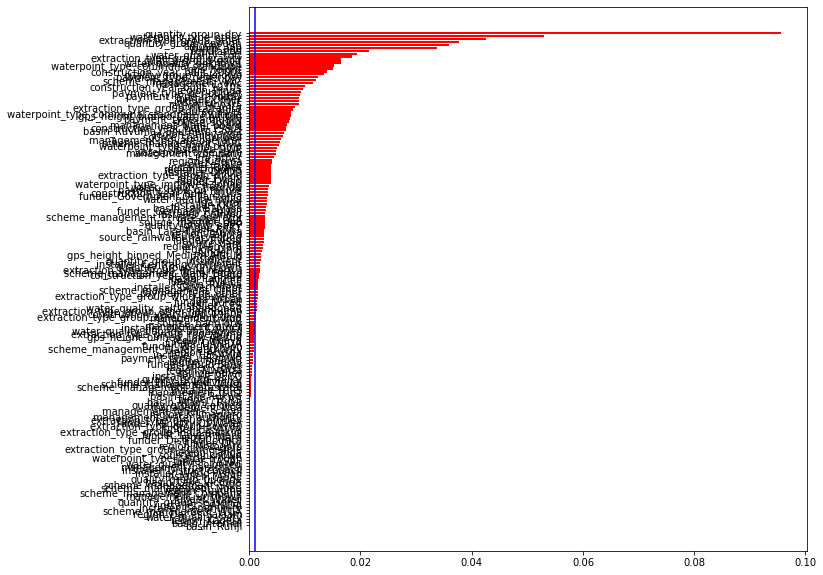

IGS 0.0009942105582325667


In [37]:
from sklearn.feature_selection import mutual_info_classif
from operator import itemgetter

ig_selector = SelectKBest(score_func=mutual_info_classif).fit(dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1), dummified_dataset.iloc[0:59400]['status_group'])


indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = defaultdict(float)
for i in range(len(dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1).columns)):
    ig_features[dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1).columns[indices[i]]] += ig_selector.scores_[indices[i]]
    
items = sorted(ig_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))

plt.figure(figsize=(10,10))
plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
plt.barh(list(range(len(keys))), values, color='r', align='center')
ig_th = pd.Series(list(ig_features.values())).quantile(0.25)*6
plt.axvline(ig_th, color='blue')
plt.gca().invert_yaxis()

plt.show()

print("IGS", ig_th)

Features to remove = dict_keys(['water_quality_fluoride abandoned', 'extraction_type_group_rope pump', 'gps_height_binned_Low Altitud', 'region_Mbeya', 'funder_DANIDA', 'funder_World Vision', 'scheme_management_Water authority', 'region_Arusha', 'installer_HESAWA', 'payment_type_unknown', 'region_Singida', 'funder_World Bank', 'installer_Gover', 'region_Mwanza', 'source_other', 'installer_WEDECO', 'quality_group_milky', 'funder_Private Individual', 'scheme_management_Trust', 'scheme_management_Parastatal', 'installer_TCRS', 'management_trust', 'basin_Lake Rukwa', 'funder_TCRS', 'basin_Wami / Ruvu', 'quality_group_colored', 'management_wua', 'management_other - school', 'region_Kilimanjaro', 'management_water authority', 'extraction_type_group_afridev', 'funder_Ministry Of Water', 'extraction_type_group_swn 80', 'funder_HESAWA', 'extraction_type_group_india mark iii', 'funder_Government', 'region_Mara', 'funder_District Council', 'funder_Dhv', 'region_Morogoro', 'extraction_type_group_s

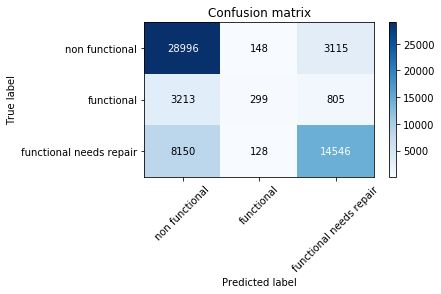

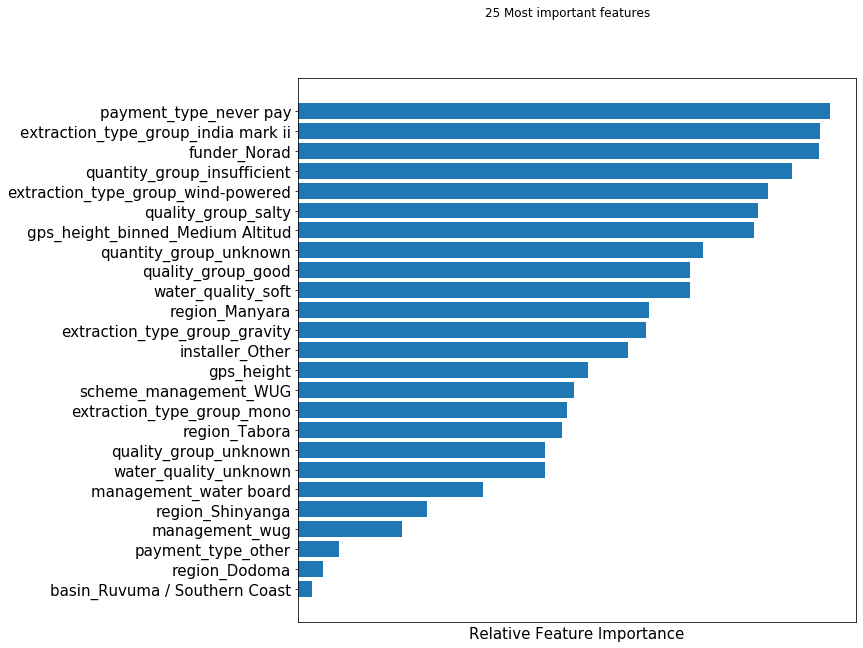

In [38]:
ig_features_to_remove = dict(filter(lambda x: x[1] <= ig_th, ig_features.items())).keys()
print("Features to remove = {}".format(ig_features_to_remove))
ig_model, score = train_model(dummified_dataset.iloc[0:59400].drop(list(ig_features_to_remove)+['status_group'], axis=1), dummified_dataset.iloc[0:59400]['status_group'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))

In [39]:
indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices[i]])
for i in range(1,len(ig_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[ig_features[:i]], y_train).predict(X_test[ig_features[:i]]))))
    print()

Features used to train the model = 1
Accuracy = 0.6455

Features used to train the model = 2
Accuracy = 0.6944

Features used to train the model = 3
Accuracy = 0.6981

Features used to train the model = 4
Accuracy = 0.6960

Features used to train the model = 5
Accuracy = 0.6986

Features used to train the model = 6
Accuracy = 0.7030

Features used to train the model = 7
Accuracy = 0.7024

Features used to train the model = 8
Accuracy = 0.7029

Features used to train the model = 9
Accuracy = 0.7051

Features used to train the model = 10
Accuracy = 0.7051

Features used to train the model = 11
Accuracy = 0.7073

Features used to train the model = 12
Accuracy = 0.7071

Features used to train the model = 13
Accuracy = 0.7062

Features used to train the model = 14


KeyboardInterrupt: 

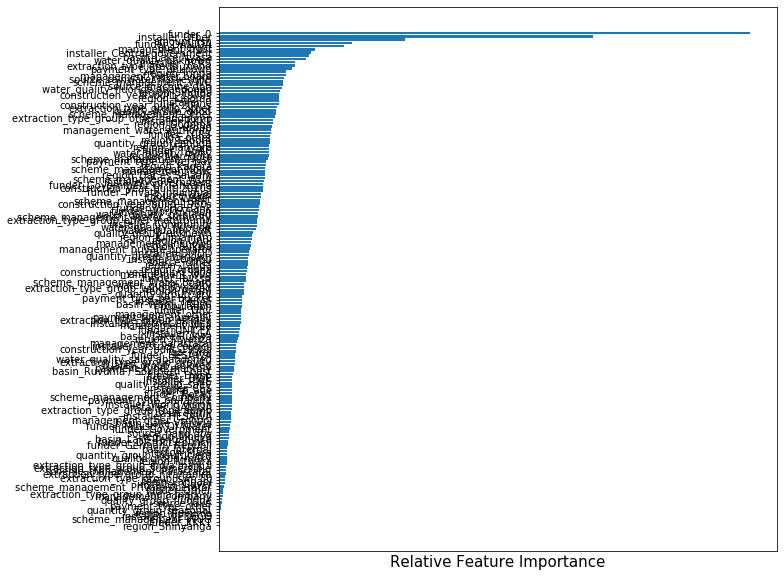

In [40]:
ig_features[:154]

ig_initial_lm_mod = linear_model.LogisticRegression(max_iter=10000, penalty='none')
ig_initial_lm_mod.fit(X_train[ig_features[:154]], y_train)

get_feature_importance1(ig_initial_lm_mod)

In [41]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:154]]))))

Accuracy = 0.7461


## Ridge

We want to learn which features best contribute to the accuracy of the model while the model is being created.
Even though  we are now penalizing the model for overfitting, we don´t see a drop of the accuracy level vs other models.
We first get the accuracy for the Ridge then for the Ridge cross-validated to see if there is an improvment.

We get a Ridge accuracy of 0.746 slightly higher than the baseline but similar to Information Gain and Ridge CV of 0.744 thus lower than normal Ridge and equals to Baseline.

In [42]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
ridge_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

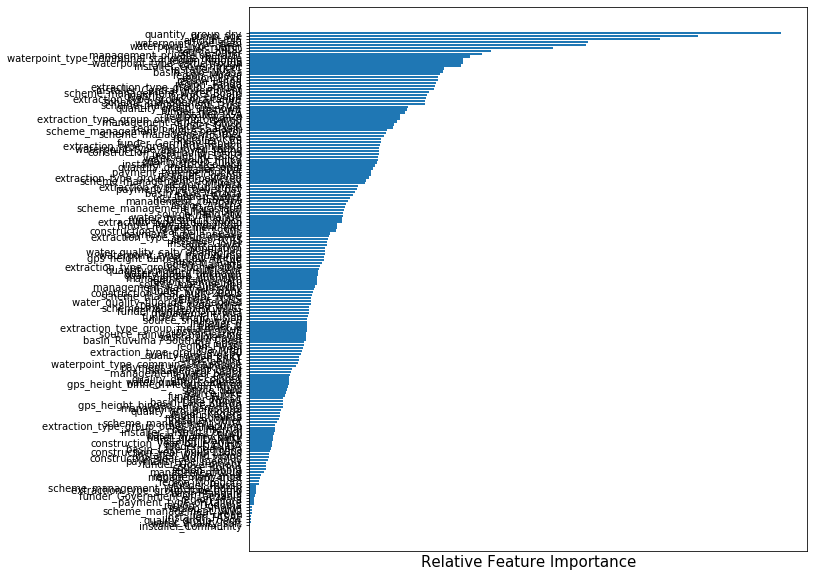

In [43]:
get_feature_importance1(ridge_mod)

In [44]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod.predict(X_test))))

Accuracy = 0.7461


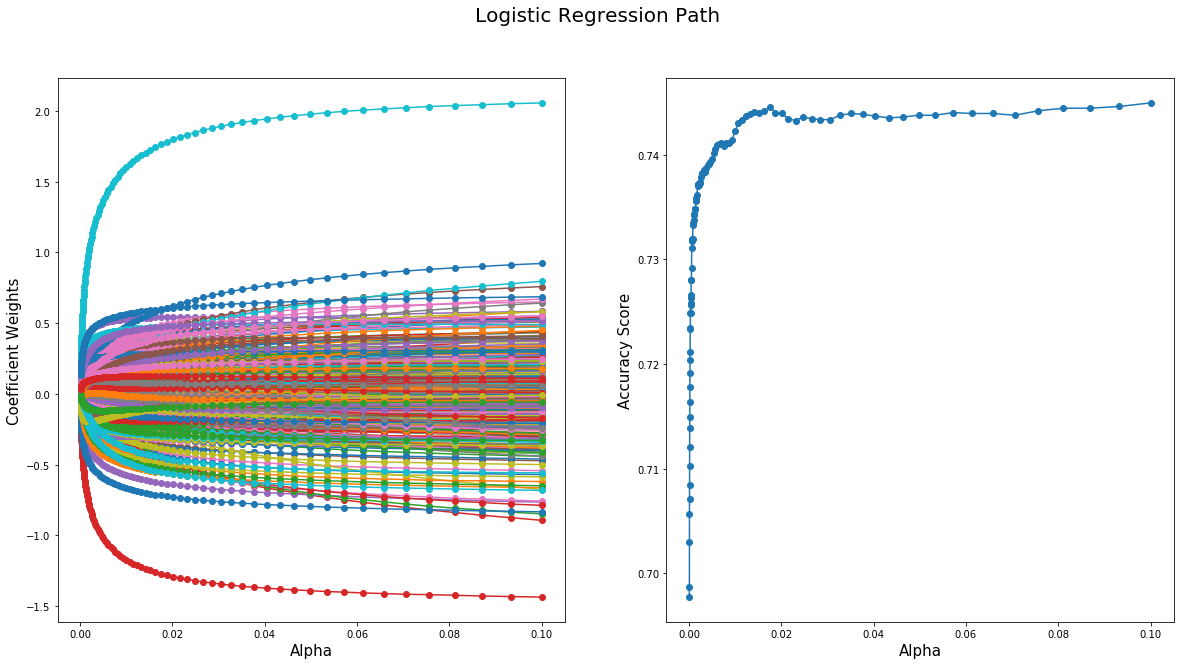

In [45]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    ridge_mod.set_params(C=a)
    ridge_mod.fit(X_train, y_train)
    coefs_.append(ridge_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,ridge_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

In [46]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X_train, y_train)

In [47]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod_cv.predict(X_test))))

Accuracy = 0.7445


## Lasso

Lasso helps even better understand the contributions of features to the accuracy of the model whhile being easier to interpret than Ridge. 
Even though the numbe rof predictors is high, it is a good idea to try it and try to get some insights from it.
Moreover it actually has the option to get featur selection.
Thus we try normal Lasso, Lasso CV and Lasso with feature selection and test all of their accuracy.

The normal one gives us an accuracy of 0.744, similar to the baseline one.

Theh CV Lasso give us 0.743 accuracy, lower than the baseline.

The feature selection Lasso gives us 0.7443 little higher than baseline.

In [49]:
lasso_mod = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
lasso_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

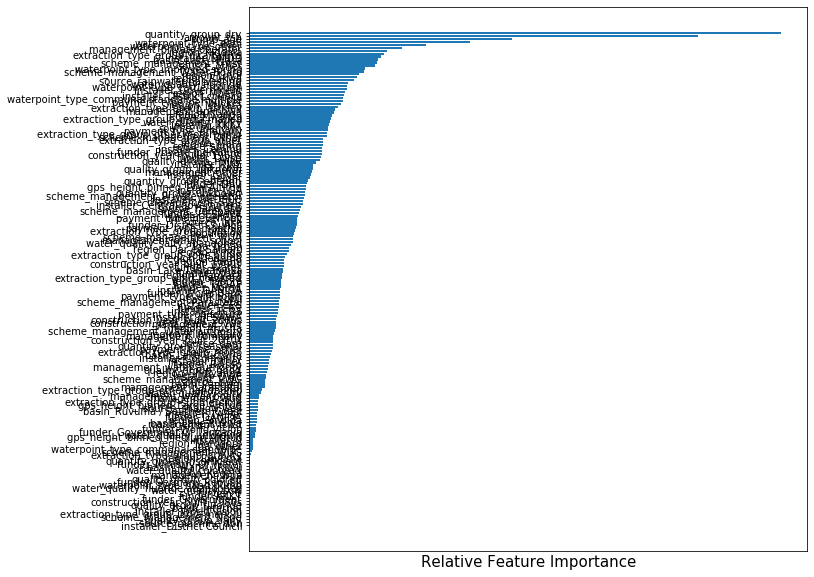

In [50]:
get_feature_importance1(lasso_mod)

In [51]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod.predict(X_test))))

Accuracy = 0.7439


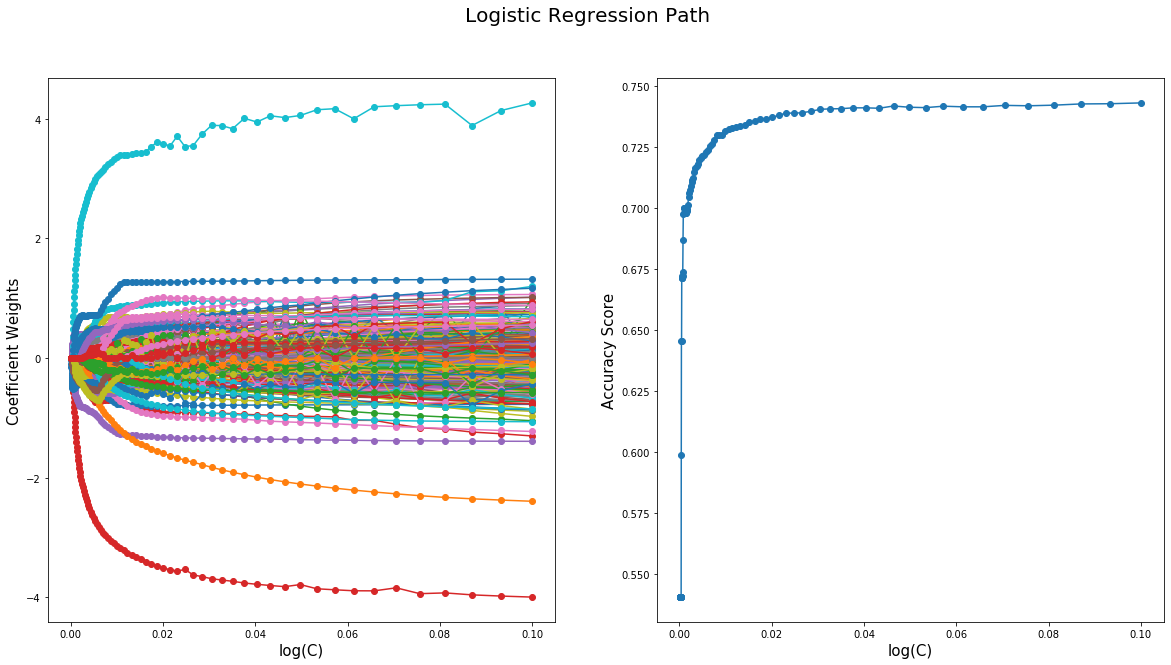

In [52]:
lasso_mod = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    lasso_mod.set_params(C=a)
    lasso_mod.fit(X_train, y_train)
    coefs_.append(lasso_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,lasso_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('log(C)', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('log(C)', fontsize = 15)
ax2.axis('tight')

plt.show()

In [53]:
from sklearn.feature_selection import SelectFromModel

lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l1',solver='liblinear',Cs=alphas).fit(X_train, y_train)

In [54]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod_cv.predict(X_test))))

Accuracy = 0.7429


In [55]:
model = SelectFromModel(lasso_mod_cv, prefit=True)
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(X_train.shape[1], X_new.shape[1]))

Original Number of Features = 168 --> Number of features selected by Lasso = 148


In [56]:
reduced_lasso_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')
reduced_lasso_mod.fit(X_new, y_train)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))))

Accuracy = 0.7443


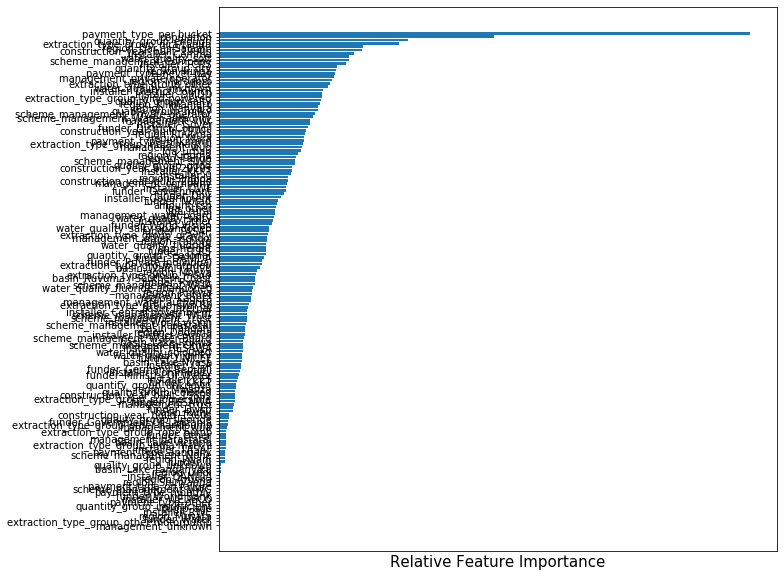

In [57]:
get_feature_importance1(reduced_lasso_mod)

## KNN

Even if this algorithm is very slow with big datasets like this one, the fact that it is intuitive and simple to interpret and a good algorithm for this type of prediction, we decide to run it and see the ouptu.
Good suprise: with an accuracy of , it's the highest scoring model as of now.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def train_model1(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    return model, score


KNN_model = KNeighborsClassifier(n_neighbors=5)

KNN_model.fit(X_train, y_train)

KNN_model, score = train_model1(dummified_dataset.iloc[0:59400].drop(['status_group'],axis=1), dummified_dataset.iloc[0:59400]['status_group'], model = KNN_model)
                               

Accuracy = 0.7680


## Decision Tree

Even though it tends to overfit, its easiness of undesrta&nding and intepreting while being able to work with both categoricla and numericla variables makes it a good candidate to train.
We do a normal and a prunned decision tree.

The normal one gives us an accuracy of 0.755, which is better than all the other models besides the KNN which has a higher accuracy.

The prunned one gives us a low score 0.715 which is the worst of them all.

In [60]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import io
import requests
from sklearn.tree import DecisionTreeClassifier

oj_tree = DecisionTreeClassifier(random_state=42)
oj_tree.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Accuracy = 0.7549


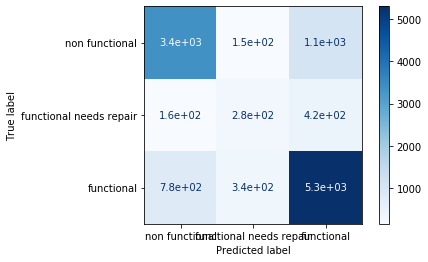

In [61]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

predictions = oj_tree.predict(X_test)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,oj_tree.predict(X_test))))
plot_confusion_matrix(oj_tree, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1,16)}

oj_tree_pruned_cv = GridSearchCV(oj_tree, 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

oj_tree_pruned_cv.fit(X_train,y_train)
print("Best parameters set found on development set:")
print()
print(oj_tree_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = oj_tree_pruned_cv.cv_results_['mean_test_score']
stds = oj_tree_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, oj_tree_pruned_cv.cv_results_['params']):
    print("MSE = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   37.4s finished


Best parameters set found on development set:

{'max_depth': 15}

Grid scores on development set:

MSE = 0.642 (+/0.005) for {'max_depth': 1}
MSE = 0.693 (+/0.004) for {'max_depth': 2}
MSE = 0.694 (+/0.002) for {'max_depth': 3}
MSE = 0.705 (+/0.006) for {'max_depth': 4}
MSE = 0.708 (+/0.004) for {'max_depth': 5}
MSE = 0.715 (+/0.006) for {'max_depth': 6}
MSE = 0.723 (+/0.006) for {'max_depth': 7}
MSE = 0.731 (+/0.012) for {'max_depth': 8}
MSE = 0.738 (+/0.008) for {'max_depth': 9}
MSE = 0.743 (+/0.005) for {'max_depth': 10}
MSE = 0.747 (+/0.007) for {'max_depth': 11}
MSE = 0.754 (+/0.007) for {'max_depth': 12}
MSE = 0.755 (+/0.007) for {'max_depth': 13}
MSE = 0.760 (+/0.008) for {'max_depth': 14}
MSE = 0.761 (+/0.007) for {'max_depth': 15}


Text(0, 0.5, 'MSE')

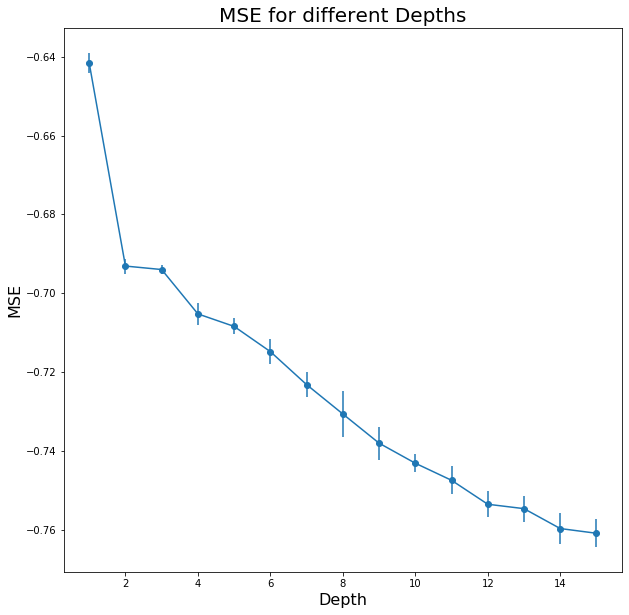

In [63]:
plt.figure(figsize=(10,10))
plt.errorbar(range(1,16,1), [-m for m in means], yerr=stds, fmt='-o')
plt.title('MSE for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("MSE", fontsize=16)

In [64]:
oj_tree_pruned = DecisionTreeClassifier(random_state=42, max_depth=6)
oj_tree_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Accuracy = 0.7152


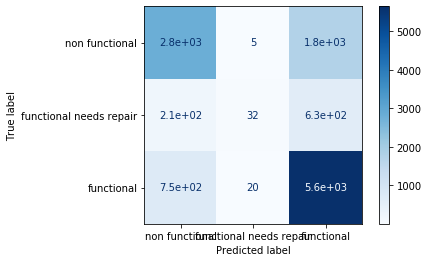

In [65]:
predictions = oj_tree_pruned.predict(X_test)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test, predictions)))
plot_confusion_matrix(oj_tree_pruned, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

## Prediction

With an accuracy of 0.768, KNN is the best model, thus we use it to fit our test set to upload it to the competition.

In [66]:
final_model = KNN_model

# Test prediction
final_pred = final_model.predict(test_t)
predictions = pd.DataFrame({'id':test['id'], 'status_group':final_pred})
predictions.to_csv("predictions_water_final.csv", index=False)